In [15]:
!pip install tensorflow_probability

In [1]:
import tensorflow as tf 
tf.__version__

'2.4.1'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5906980945621592247,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4949437312
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 214375221417780296
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [3]:
import numpy as np
import tensorflow as tf 
import gym
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls

In [4]:
env= gym.make("CartPole-v0")
low = env.observation_space.low
high = env.observation_space.high

In [5]:
class critic(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(128,activation='relu')
        self.v = tf.keras.layers.Dense(1, activation = None)

    def call(self, input_data):
        x = self.d1(input_data)
        v = self.v(x)
        return v

class actor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(128,activation='relu')
        self.a = tf.keras.layers.Dense(2,activation='softmax')

    def call(self, input_data):
        x = self.d1(input_data)
        a = self.a(x)
        return a

In [6]:
class agent():
    def __init__(self, gamma = 0.99):
        self.gamma = gamma
        self.a_opt = tf.keras.optimizers.Adam(learning_rate=7e-3)
        self.c_opt = tf.keras.optimizers.Adam(learning_rate=7e-3)
        self.actor = actor()
        self.critic = critic()
        self.clip_pram = 0.2

          
    def act(self,state):
        prob = self.actor(np.array([state]))
        prob = prob.numpy()
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        action = dist.sample()
        return int(action.numpy()[0])
    
    def actor_loss(self, probs, actions, adv, old_probs, closs):
        
        probability = probs      
        entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probability,tf.math.log(probability))))
        sur1 = []
        sur2 = []
        
        for pb, t, op in zip(probability, adv, old_probs):
                        t =  tf.constant(t)
                        op =  tf.constant(op)
                        ratio = tf.math.divide(pb,op)
                        s1 = tf.math.multiply(ratio,t)
                        s2 =  tf.math.multiply(tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram),t)
                        sur1.append(s1)
                        sur2.append(s2)

        sr1 = tf.stack(sur1)
        sr2 = tf.stack(sur2)

        loss = tf.math.negative(tf.reduce_mean(tf.math.minimum(sr1, sr2)) - closs + 0.001 * entropy)
        return loss
    
    def learn(self, states, actions,  adv , old_probs, discnt_rewards):
        discnt_rewards = tf.reshape(discnt_rewards, (len(discnt_rewards),))
        adv = tf.reshape(adv, (len(adv),))

        old_p = old_probs

        old_p = tf.reshape(old_p, (len(old_p),2))
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            p = self.actor(states, training=True)
            v =  self.critic(states,training=True)
            v = tf.reshape(v, (len(v),))
            td = tf.math.subtract(discnt_rewards, v)
            c_loss = 0.5 * kls.mean_squared_error(discnt_rewards, v)
            a_loss = self.actor_loss(p, actions, adv, old_probs, c_loss)
            
        grads1 = tape1.gradient(a_loss, self.actor.trainable_variables)
        grads2 = tape2.gradient(c_loss, self.critic.trainable_variables)
        self.a_opt.apply_gradients(zip(grads1, self.actor.trainable_variables))
        self.c_opt.apply_gradients(zip(grads2, self.critic.trainable_variables))
        return a_loss, c_loss

In [7]:
def test_reward(env):
    total_reward = 0
    state = env.reset()
    done = False
    while not done:
        action = np.argmax(agentoo7.actor(np.array([state])).numpy())
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward

    return total_reward

In [8]:
def preprocess1(states, actions, rewards, done, values, gamma):
    g = 0
    lmbda = 0.95
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
        g = delta + gamma * lmbda * dones[i] * g
        returns.append(g + values[i])

    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    adv = (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    states = np.array(states, dtype=np.float32)
    actions = np.array(actions, dtype=np.int32)
    returns = np.array(returns, dtype=np.float32)
    return states, actions, returns, adv

In [9]:
tf.random.set_seed(336699)
agentoo7 = agent()
steps = 5000
ep_reward = []
total_avgr = []
target = False 
best_reward = 0
avg_rewards_list = []


for s in range(steps):
    if target == True:
          break
            
    done = False
    state = env.reset()
    all_aloss = []
    all_closs = []
    rewards = []
    states = []
    actions = []
    probs = []
    dones = []
    values = []
    print("new episode")

    for e in range(128):
        action = agentoo7.act(state)
        value = agentoo7.critic(np.array([state])).numpy()
        next_state, reward, done, _ = env.step(action)
        dones.append(1-done)
        rewards.append(reward)
        states.append(state)
        actions.append(action)
        prob = agentoo7.actor(np.array([state]))
        probs.append(prob[0])
        values.append(value[0][0])
        state = next_state
        if done:
            env.reset()
            
    value = agentoo7.critic(np.array([state])).numpy()
    values.append(value[0][0])
    np.reshape(probs, (len(probs),2))
    probs = np.stack(probs, axis=0)

    states, actions,returns, adv  = preprocess1(states, actions, 
                                                rewards, dones, values, 1)

    for epocs in range(10):
        al,cl = agentoo7.learn(states, actions, adv, probs, returns)
        
    avg_reward = np.mean([test_reward(env) for _ in range(5)])
    print(f"total test reward is {avg_reward}")
    avg_rewards_list.append(avg_reward)
    if avg_reward > best_reward:
        print('best reward=' + str(avg_reward))
        agentoo7.actor.save('model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        agentoo7.critic.save('model_critic_{}_{}'.format(s, avg_reward), save_format="tf")
        best_reward = avg_reward
    if best_reward == 200:
        target = True
    env.reset()
env.close()

new episode
total test reward is 37.6
best reward=37.6
INFO:tensorflow:Assets written to: model_actor_0_37.6\assets
INFO:tensorflow:Assets written to: model_critic_0_37.6\assets
new episode
total test reward is 102.6
best reward=102.6
INFO:tensorflow:Assets written to: model_actor_1_102.6\assets
INFO:tensorflow:Assets written to: model_critic_1_102.6\assets
new episode
total test reward is 70.8
new episode
total test reward is 52.8
new episode
total test reward is 49.4
new episode
total test reward is 83.8
new episode
total test reward is 103.0
best reward=103.0
INFO:tensorflow:Assets written to: model_actor_6_103.0\assets
INFO:tensorflow:Assets written to: model_critic_6_103.0\assets
new episode
total test reward is 82.0
new episode
total test reward is 73.6
new episode
total test reward is 63.8
new episode
total test reward is 116.4
best reward=116.4
INFO:tensorflow:Assets written to: model_actor_10_116.4\assets
INFO:tensorflow:Assets written to: model_critic_10_116.4\assets
new epis

In [10]:
import matplotlib.pyplot as plt

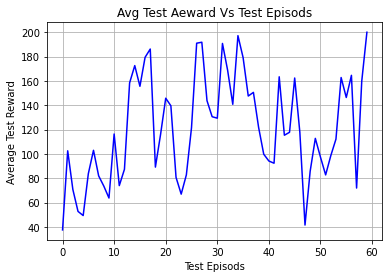

In [11]:
ep = [i  for i in range(len(avg_rewards_list))]
plt.plot( range(len(avg_rewards_list)),avg_rewards_list,'b')
plt.title("Avg Test Aeward Vs Test Episods")
plt.xlabel("Test Episods")
plt.ylabel("Average Test Reward")
plt.grid(True)
plt.show()